Map cell types to 19pcw and 14pcw data. Save the results and produce cell type maps

Load libraries and data:

In [1]:
import sys,os
path = '/nfs/team283/aa16/KR_NAS/'
os.chdir(path)
sys.path.append(path)

In [2]:
import pickle
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
import isctools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:89:00.0)


In [3]:
adata_wta = pickle.load(open("/nfs/team283/aa16/InSituCellTools/data/nanostringWTA_fetailBrain_AnnData.p", "rb" ))

In [4]:
adata_wta = adata_wta[adata_wta.obs['GoodQuality'],:]

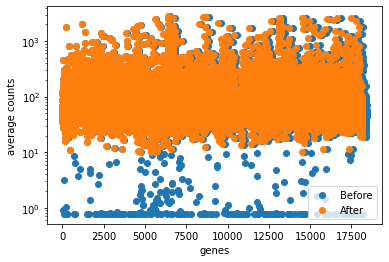

In [5]:
plt.scatter(range(np.shape(adata_wta.X)[1]), np.mean(adata_wta.X, axis = 0), label = 'Before')
plt.yscale('log')
plt.xlabel('genes')
plt.ylabel('average counts')

adata_wta = adata_wta[:, np.mean(adata_wta.X, axis = 0) < 3000]
adata_wta = adata_wta[:, np.mean(adata_wta.X, axis = 0) > 10]

plt.scatter(range(np.shape(adata_wta.X)[1]), np.mean(adata_wta.X, axis = 0), label = 'After')
plt.yscale('log')
plt.xlabel('genes')
plt.ylabel('average counts')
plt.legend()

In [6]:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

In [ ]:
np.shape(meanExpression_sc)

Make sure we have the same genes in reference and spatial data:

In [7]:
wta_genes = np.asarray(adata_wta.var_names)
common_genes = [wta_genes[i] for i in range(len(wta_genes)) if wta_genes[i] in meanExpression_sc.index] 
adata_wta = adata_wta[:,[adata_wta.var_names[i] in common_genes + ['NegProbe-WTX'] for i in range(len(adata_wta.var_names))]]
meanExpression_sc = meanExpression_sc.reindex(index = common_genes)

Fit each slide seperately:

In [8]:
slides = np.array(('00MR','00MU', ('00MV', '00MV-2'), '00MW'))
adata_slide = list()
for j in range(len(slides)):
    adata_slide.append(adata_wta[[adata_wta.obs['slide'][i] in slides[j] for i in range(len(adata_wta.obs['slide']))]])
    print(np.shape(adata_slide[j]))

(66, 15077)
(74, 15077)
(52, 15077)
(63, 15077)


In [9]:
counts_geneProbes = list()
counts_negativeProbes = list()
counts_nuclei = list()

for i in range(len(slides)):
    counts_geneProbes.append(np.asarray(adata_slide[i][:,np.array(adata_slide[i].var != 'NegProbe-WTX').squeeze()].X))
    counts_negativeProbes.append(np.asarray(adata_slide[i][:,np.array(adata_slide[i].var =='NegProbe-WTX').squeeze()].X))
    counts_nuclei.append(np.asarray(adata_slide[i].obs['nuclei']).reshape(len(adata_slide[i].obs['nuclei']),1))

celltypes = meanExpression_sc.keys()
meanExpression_sc = np.asarray(meanExpression_sc)

In [10]:
celltypes

Index(['End', 'ExDp1', 'ExDp2', 'ExM', 'ExM-U', 'ExN', 'InCGE', 'InMGE', 'IP',
       'Mic', 'OPC', 'oRG', 'Per', 'PgG2M', 'PgS', 'vRG'],
      dtype='object')

In [11]:
models = list()
for i in range(len(slides)):
    models.append(isctools.ProbeCounts_CoLocationModel_NB_V1(
            cell_state_mat = meanExpression_sc,
            X_data = counts_geneProbes[i],
            Y_data = counts_negativeProbes[i],
            data_type='float32',
            n_iter=50000,
            learning_rate=0.001,
            fact_names=celltypes,
            gene_level_prior={'mean': 1/2, 'sd': 1/8, 'mean_var_ratio': 0.25},
            cell_number_prior={'cells_per_spot': counts_nuclei[i], 'factors_per_spot': 6, 'combs_per_spot': 5},
            cell_number_var_prior={'cells_mean_var_ratio': 0.1, 'factors_mean_var_ratio': 1, 'combs_mean_var_ratio': 1}))

Fitting for slide:  00MR


Average Loss = 9.5914e+06: 100%|██████████| 50000/50000 [03:34<00:00, 232.99it/s]
Finished [100%]: Average Loss = 9.5914e+06


Fitting for slide:  00MU


Average Loss = 1.5572e+07: 100%|██████████| 50000/50000 [03:44<00:00, 222.59it/s]
Finished [100%]: Average Loss = 1.5572e+07


Fitting for slide:  ('00MV', '00MV-2')


Average Loss = 1.1341e+07: 100%|██████████| 50000/50000 [03:18<00:00, 252.45it/s]
Finished [100%]: Average Loss = 1.1341e+07


Fitting for slide:  00MW


Average Loss = 1.1536e+07: 100%|██████████| 50000/50000 [03:32<00:00, 234.91it/s]
Finished [100%]: Average Loss = 1.1536e+07


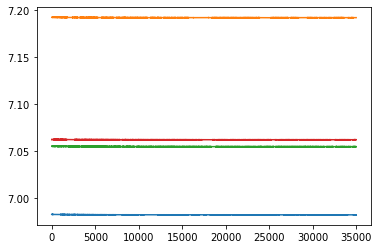

In [12]:
for i in range(len(slides)):
    print('Fitting for slide: ', slides[i])
    models[i].fit_advi_iterative(n_iter = 50000, learning_rate = 0.001, n=1, method='advi')

Plot history and stability:

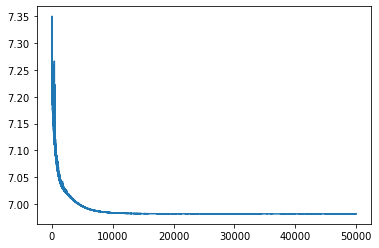

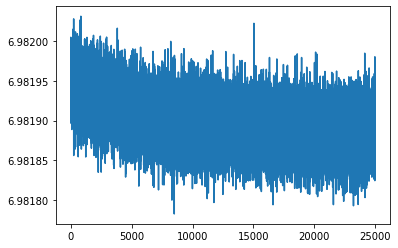

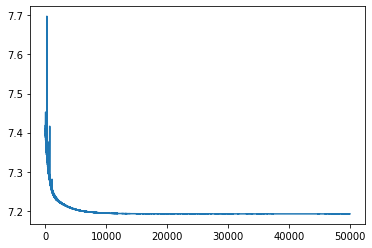

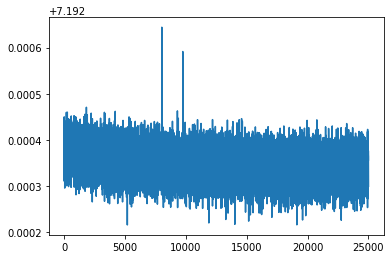

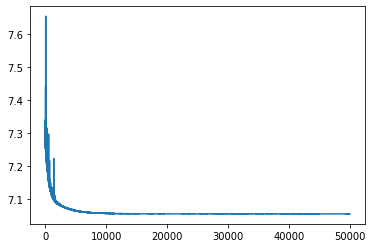

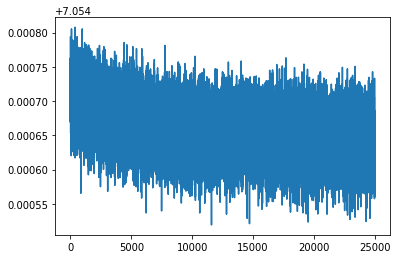

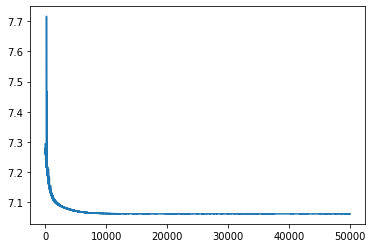

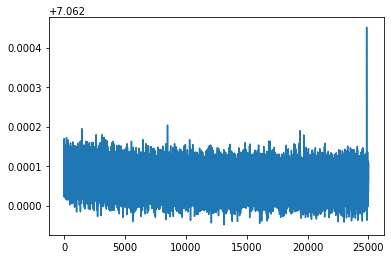

In [13]:
for i in range(len(slides)):
    models[i].plot_history()
    plt.show()
    models[i].plot_history(25000)
    plt.show()
    models[i].evaluate_stability()
    plt.show()

Evaluate posterior and plot it vs data:

00MR


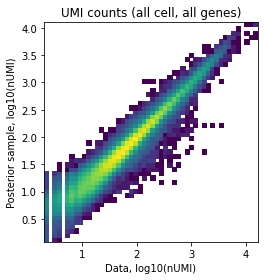

00MU


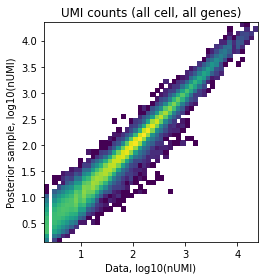

('00MV', '00MV-2')


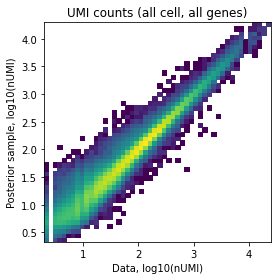

00MW


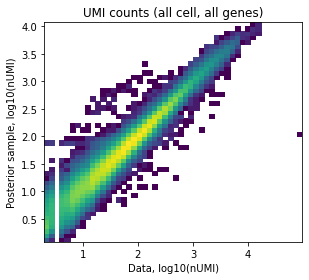

In [14]:
for i in range(len(slides)):
    print(slides[i])
    models[i].sample_posterior(node='all', n_samples=1000, save_samples=False);
    isctools.ProbeCounts_CoLocationModel_Poisson.compute_expected(models[i])
    models[i].plot_posterior_mu_vs_data()
    plt.show()

Calculate the spot factors:

In [15]:
for i in range(len(slides)):
    models[i].sample2df(node_name='spot_factors')

Save models just in case:

In [16]:
pickle.dump(models, file = open( "0_publication_figures_scripts/models.p", "wb" ))

In [36]:
models = pickle.load(open('0_publication_figures_scripts/models.p', 'rb'))

In [45]:
subset = [adata_slide[1].obs['nuclei'][i] < 150 and adata_slide[1].obs['slide'][i] == '00MU' and 
adata_slide[1].obs['AOI_type'][i] == 'Geometric' for i in
         range(len(adata_slide[1].obs['nuclei']))]
models[1].spot_factors_df.loc[subset,:]

,mean_spot_factorsEnd,mean_spot_factorsExDp1,mean_spot_factorsExDp2,mean_spot_factorsExM,mean_spot_factorsExM-U,mean_spot_factorsExN,mean_spot_factorsInCGE,mean_spot_factorsInMGE,mean_spot_factorsIP,mean_spot_factorsMic,mean_spot_factorsOPC,mean_spot_factorsoRG,mean_spot_factorsPer,mean_spot_factorsPgG2M,mean_spot_factorsPgS,mean_spot_factorsvRG
c_12,0.036875,0.213881,0.038916,0.195306,0.222274,0.406859,130.295776,29.616560,0.896634,1.019164,0.031540,0.058809,0.071943,25.131969,0.415682,150.993073
c_19,0.894075,0.030108,0.010032,0.038852,0.038614,0.107184,63.637810,12.260362,0.257174,1.125099,0.030929,0.030184,1.157488,13.688655,0.127986,57.406258
c_25,0.052876,0.054869,0.013361,0.079671,0.276590,0.152703,30.191618,8.136133,3.385303,0.593057,0.025713,0.018723,0.027009,0.175519,0.097600,29.317959
c_32,0.009208,0.023639,0.006660,0.064340,0.072418,0.203374,12.786198,0.741569,1.088946,0.501510,0.008015,0.009331,0.093417,0.458564,0.066707,12.647546


In [48]:
adata_slide[1].obs['nuclei'].loc[subset]

AttributeError: 'AnnData' object has no attribute 'slide'

In [ ]:
np.array(adata_slide[1].obs.loc[:,('AOI_type', 'nuclei','VCDepth')].loc[subset])

Overview plot of the cell locations in the 19pcw and 14pcw samples:

In [13]:
subset_plot = list()
for i in range(len(slides)):
    subset_plot.append([adata_slide[i].obs['AOI_type'][j] == 'Geometric' and
                        adata_slide[i].obs['Radial_position'][j] == 2 for j in range(len(adata_slide[i].obs['AOI_type']))])

We use the colour code that we use for all figures:

In [14]:
colourCode = pickle.load(open('../KR_NAS/0_publication_figures_scripts/celltypesColourCode.p',  "rb"))

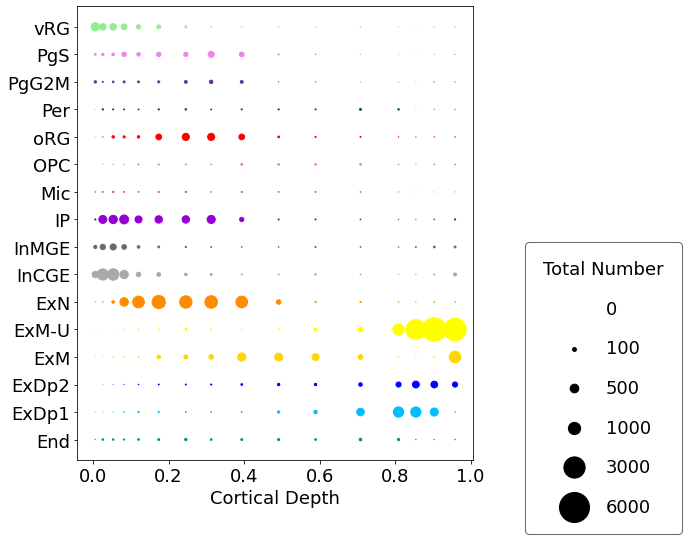

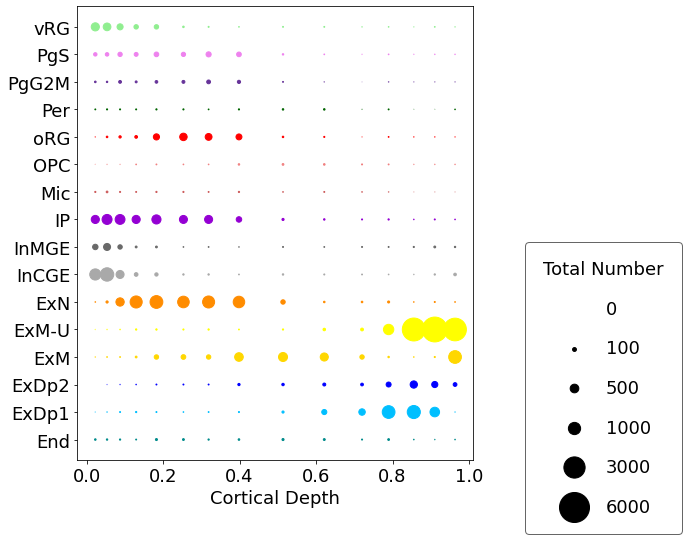

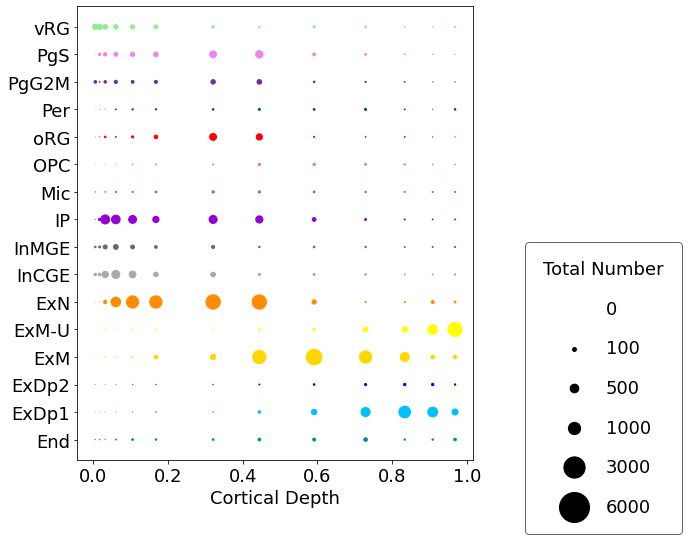

In [15]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 0.15
power = 1

labels = ('19pcw_other', '19pcw_1', '19pcw_2', '14pcw_1')

for i in range(1,4):
    
    celltypesForPlot = np.repeat(models[i].fact_names,sum(subset_plot[i]))
    vcForPlot = np.array([adata_slide[i].obs['VCDepth'].loc[subset_plot[i]] for j in range(len(models[i].fact_names))]).flatten()
    countsForPlot = np.array([models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]] for j in range(len(models[i].fact_names))])
    coloursForPlot = np.array(colourCode.loc[np.array((celltypesForPlot)),'Colour'])
    
    cmap = matplotlib.cm.get_cmap('autumn')

    plt.figure(figsize = (12,8))
    plt.scatter(vcForPlot, celltypesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
                c= coloursForPlot)

    plt.xlabel('Cortical Depth')

    # make a legend:
    pws = [0,0,100,500,1000,3000,6000]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Total Number", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))
    plt.tight_layout()
    plt.savefig('0_publication_figures/Figure3_CelltypeMap_TotalNumber_' + labels[i] + '.pdf')
    

Now make the same plot with density and make a new cellorder:

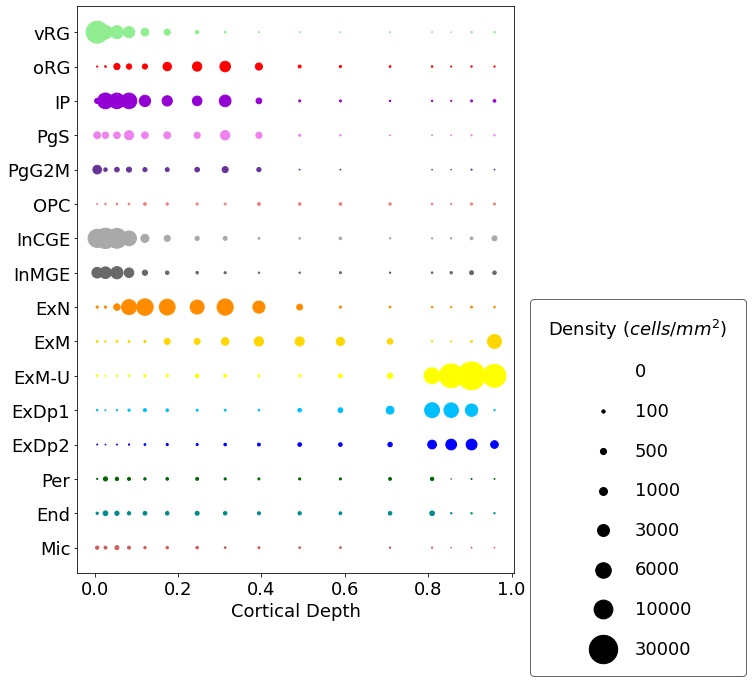

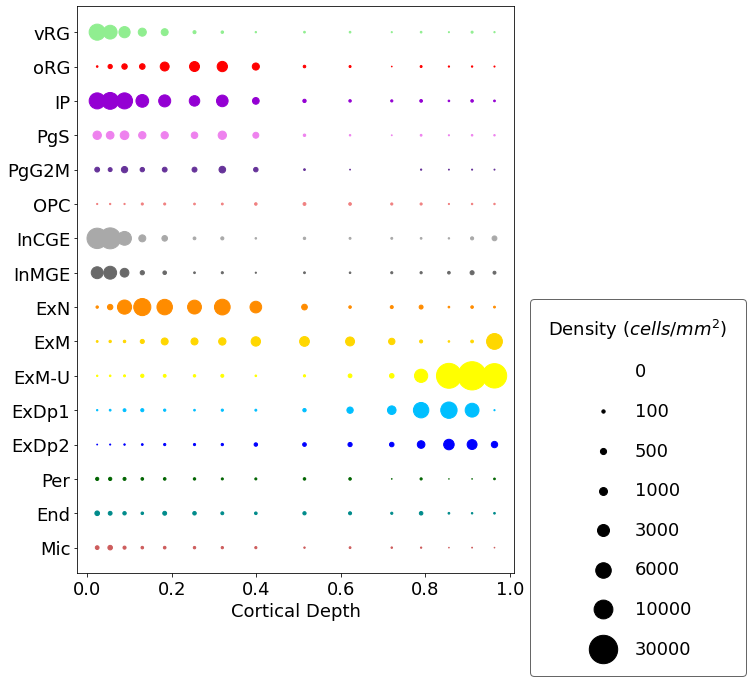

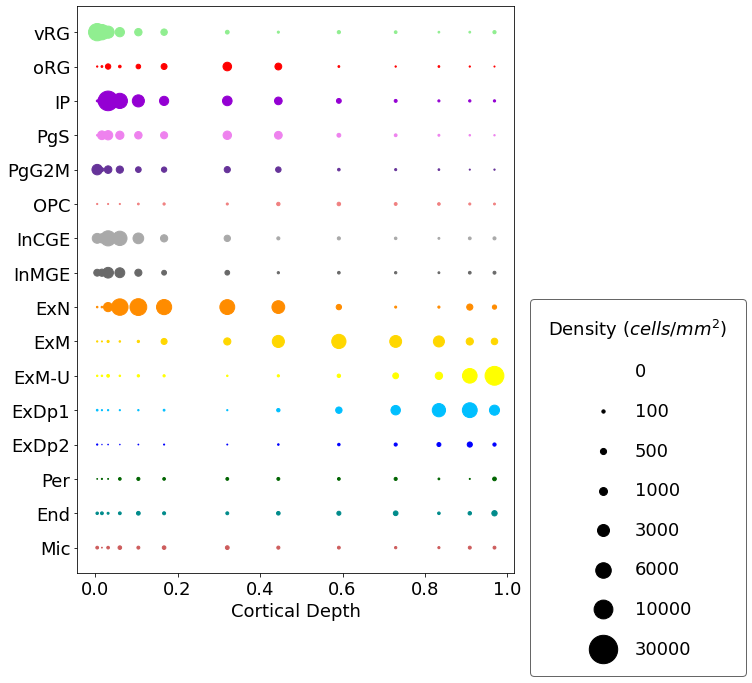

In [16]:
# Reorder cell types:
cellorder = np.array(['vRG','oRG', 'IP', 'PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN','ExM','ExM-U', 'ExDp1', 'ExDp2', 'Per', 'End', 'Mic'])

neworder = np.flipud([np.where(models[i].fact_names == cellorder[j])[0][0] for j in range(len(cellorder))])

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 0.25
power = 0.75

labels = ('19pcw_other', '19pcw_1', '19pcw_2', '14pcw_1')

for i in range(1,4):
    
    roi_dimension = np.array(adata_slide[i].obs['roi_dimension'].iloc[:,0])
    
    celltypesForPlot = np.repeat(models[i].fact_names[neworder],sum(subset_plot[i]))
    vcForPlot = np.array([adata_slide[i].obs['VCDepth'].loc[subset_plot[i]] for j in range(len(models[i].fact_names))]).flatten()
    countsForPlot = np.array([models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]]/roi_dimension[subset_plot[i]]*10**6
                              for j in neworder])
    coloursForPlot = np.array(colourCode.loc[np.array((celltypesForPlot)),'Colour'])
    
    cmap = matplotlib.cm.get_cmap('autumn')

    plt.figure(figsize = (13,10))
    plt.scatter(vcForPlot, celltypesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
                c= coloursForPlot)

    plt.xlabel('Cortical Depth')

    # make a legend:
    pws = [0,0,100,500,1000,3000,6000,10000, 30000]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Density ($cells/mm^2$)", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))
    plt.tight_layout()
    plt.savefig('0_publication_figures/Figure3_CelltypeMap_Density_ManualOrder' + labels[i] + '.pdf')

Finally make this plot with proportion:

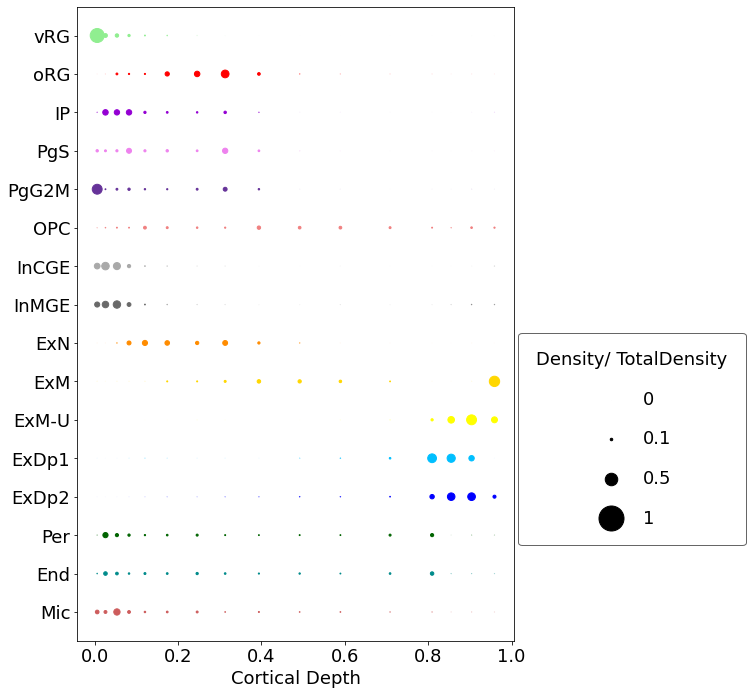

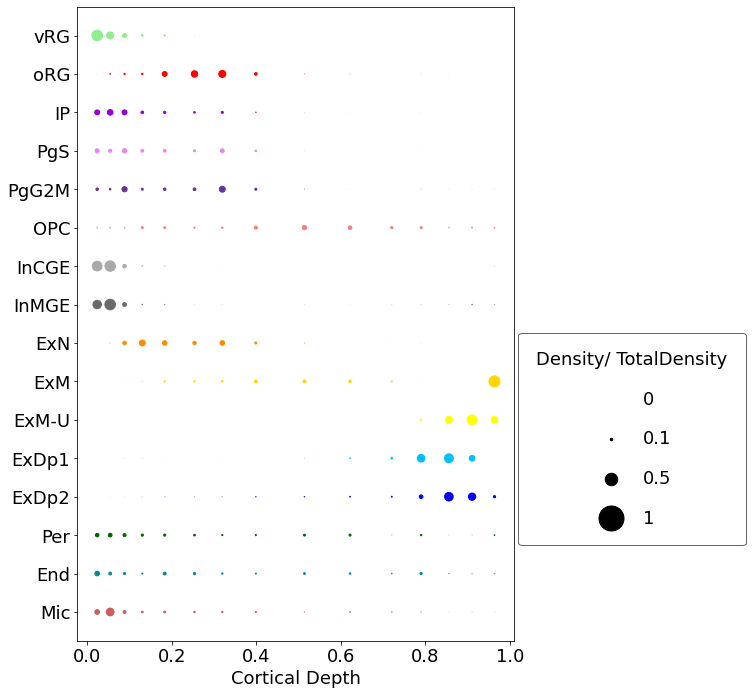

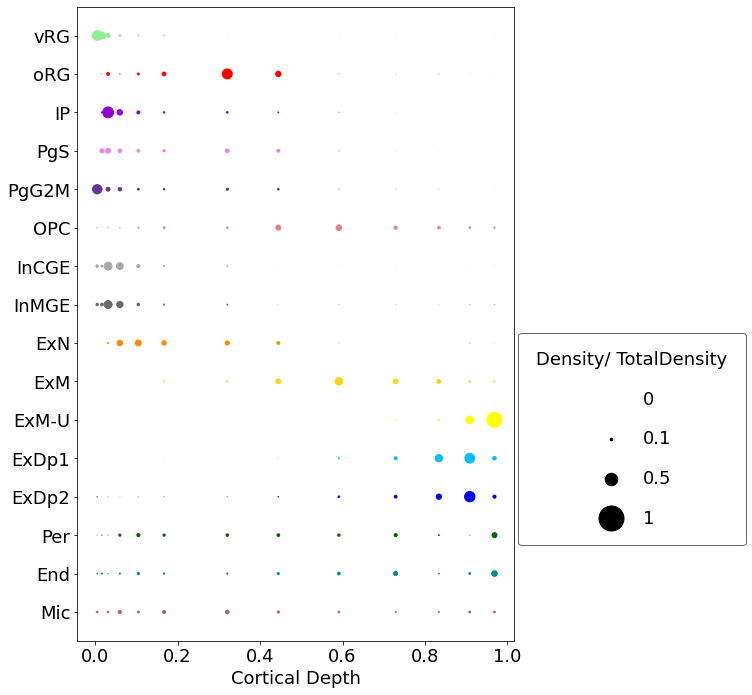

In [17]:
# Reorder cell types:
cellorder = np.array(['vRG','oRG', 'IP', 'PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN','ExM','ExM-U', 'ExDp1', 'ExDp2', 'Per', 'End', 'Mic'])

neworder = np.flipud([np.where(models[i].fact_names == cellorder[j])[0][0] for j in range(len(cellorder))])

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 25
power = 2

labels = ('19pcw_other', '19pcw_1', '19pcw_2', '14pcw_1')

for i in range(1,4):
    
    roi_dimension = np.array(adata_slide[i].obs['roi_dimension'].iloc[:,0])
    
    celltypesForPlot = np.repeat(models[i].fact_names[neworder],sum(subset_plot[i]))
    vcForPlot = np.array([adata_slide[i].obs['VCDepth'].loc[subset_plot[i]] for j in range(len(models[i].fact_names))]).flatten()
    countsForPlot = np.array([models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]]/roi_dimension[subset_plot[i]]*10**6/
                              sum((models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]]/roi_dimension[subset_plot[i]]*10**6))
                              for j in neworder])
    coloursForPlot = np.array(colourCode.loc[np.array((celltypesForPlot)),'Colour'])
    
    cmap = matplotlib.cm.get_cmap('autumn')

    plt.figure(figsize = (13,10))
    plt.scatter(vcForPlot, celltypesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
                c= coloursForPlot)

    plt.xlabel('Cortical Depth')

    # make a legend:
    pws = [0,0,0.1,0.5,1]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Density/ TotalDensity", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))
    plt.tight_layout()
    plt.savefig('0_publication_figures/Figure3_CelltypeMap_Density_Normalized_ManualOrder' + labels[i] + '.pdf')

Finally, make a line plot only for oRGs:

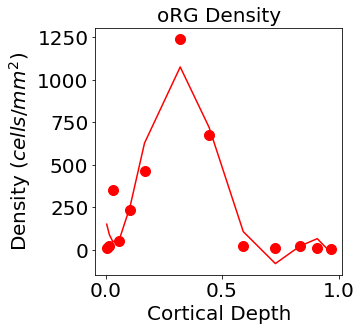

In [18]:
# Set figure parameters:

j = np.where(models[i].fact_names == 'oRG')[0][0]

polynomial_order = 6
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(1,1, figsize = (5.5,5))

x = adata_slide[i].obs['VCDepth']
y = models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]]/roi_dimension[subset_plot[i]]*10**6

ax.plot(np.unique(x[subset_plot[i]]), np.poly1d(np.polyfit(x[subset_plot[i]], y, polynomial_order))(np.unique(x[subset_plot[i]])), c = 'red')
ax.scatter(x[subset_plot[i]], y, c = 'red', s = 100)
ax.set_xlabel('Cortical Depth')
ax.set_ylabel('Density ($cells/ mm^2$)')
ax.set_title('oRG Density')

plt.tight_layout()

plt.savefig('../KR_NAS/0_publication_figures/Figure3A_oRG_Lineplot_Density.pdf')

plt.show()

In [19]:
adata = pickle.load(open('../KR_NAS/data/nanostringWTA_fetailBrain_AnnData.p', 'rb'))

Finally make a plot of biological replicate 2:

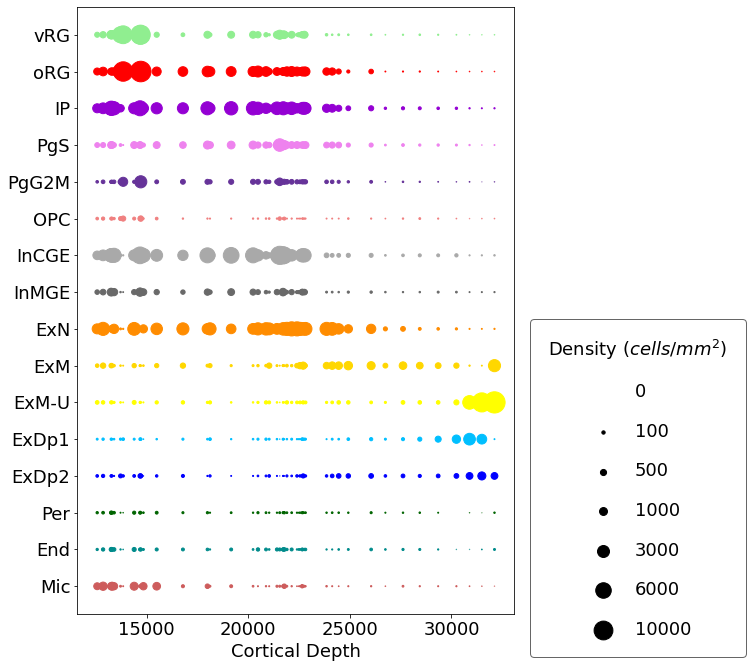

In [34]:
subset_plot1 = [adata.obs['AOI_type'][j] == 'Geometric' and
               adata.obs['slide'][j] == '00MR' for j in range(len(adata.obs['AOI_type']))]

subset_plot2 = [adata_slide[0].obs['AOI_type'][j] == 'Geometric' and
               adata_slide[0].obs['slide'][j] == '00MR' for j in range(len(adata_slide[0].obs['AOI_type']))]

i = 0

# Reorder cell types:
cellorder = np.array(['vRG','oRG', 'IP', 'PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN','ExM','ExM-U', 'ExDp1', 'ExDp2', 'Per', 'End', 'Mic'])

neworder = np.flipud([np.where(models[i].fact_names == cellorder[j])[0][0] for j in range(len(cellorder))])

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 0.25
power = 0.75

labels = ('19pcw_other', '19pcw_1', '19pcw_2', '14pcw_1')

roi_dimension = np.array(adata.obs['roi_dimension'].iloc[:,0])

celltypesForPlot = np.repeat(models[i].fact_names[neworder],sum(subset_plot1))
vcForPlot = np.array([adata.obs['X_coordinate'].loc[subset_plot1] for j in range(len(models[i].fact_names))]).flatten()
countsForPlot = np.array([models[i].spot_factors_df.iloc[:,j].loc[subset_plot2]/roi_dimension[subset_plot1]*10**6
                          for j in neworder])
coloursForPlot = np.array(colourCode.loc[np.array((celltypesForPlot)),'Colour'])

cmap = matplotlib.cm.get_cmap('autumn')

plt.figure(figsize = (13,10))
plt.scatter(vcForPlot, celltypesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= coloursForPlot)

plt.xlabel('X-coordinate')

# make a legend:
pws = [0,0,100,500,1000,3000,6000,10000]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Density ($cells/mm^2$)", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/CelltypeMap_Density_ManualOrder_BiologicalReplicate2.pdf')